In [1]:
import torch
import os
import numpy as np
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from PIL import Image
import requests
from io import BytesIO
import random
from IPython.display import display
import matplotlib.pyplot as plt
import torchvision

In [2]:
vgg16 = models.vgg16(pretrained = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.eval()

modules = list(vgg16.features.modules())
model = vgg16

In [61]:
vgg19 = models.vgg19(pretrained = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)
vgg19.eval()

modules = list(vgg19.features.modules())
model = vgg19

In [3]:
def get_image(url, max_dim=None):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  if (max_dim):
    image.thumbnail((max_dim, max_dim))              # .thumbnail preserves aspect ratio/always downsizes/always fits in max_dim x max_dim     
  return image

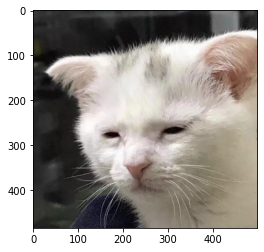

In [4]:
url = "https://i.redd.it/f67tf7ld9s431.jpg"
max_dim = 500
init = get_image(url, max_dim)
plt.imshow(init)

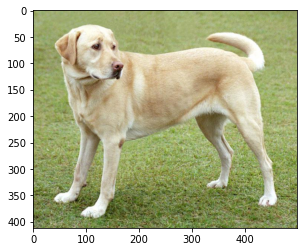

In [78]:
url = "https://www.tensorflow.org/tutorials/generative/deepdream_files/output_Y5BPgc8NNbG0_1.png"
max_dim = 500
init = get_image(url, max_dim)
plt.imshow(init)

In [5]:
def dream(image, model, modules, target_layer, lr, iterations):
  input = image.unsqueeze(0).to(device)
  input.requires_grad = True
  model.zero_grad()
  for i in range(iterations):
    temp = input
    for layer in range(target_layer):
      temp = modules[layer + 1](temp)
    loss = temp.norm()
    loss.backward()
    input.data = input.data + lr * (input.grad) #some pytorch weirdness goign on here. data is deprecated but detach() doesnt work?
  
  return input.squeeze()

In [6]:
normalize = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # mean & stdev values from ImageNet
])
denormalize = transforms.Compose([
  transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]),
  transforms.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.]),
])

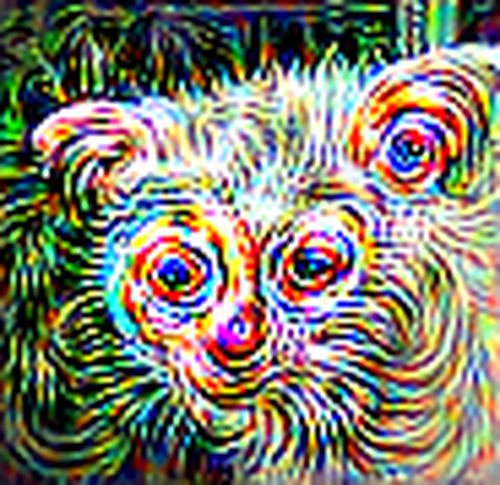

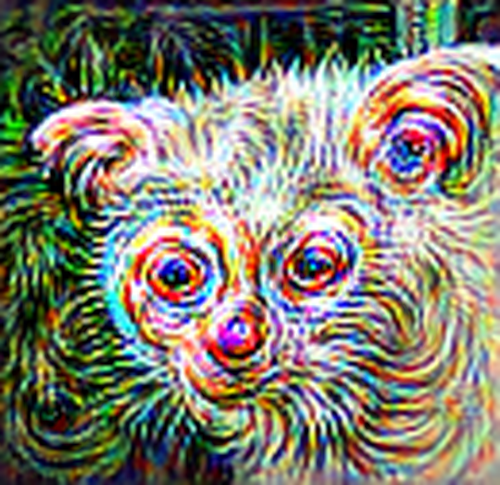

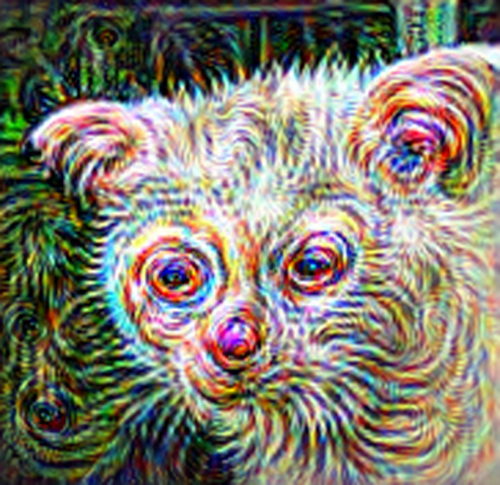

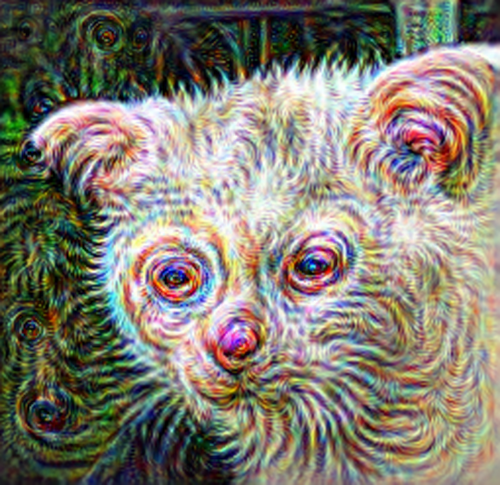

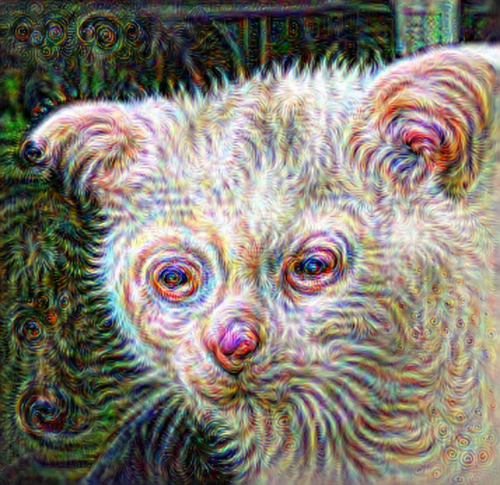

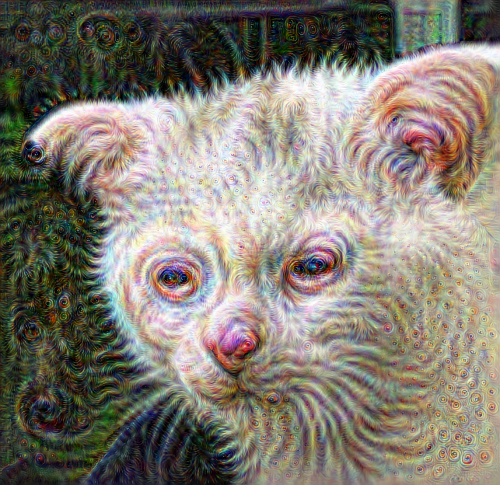

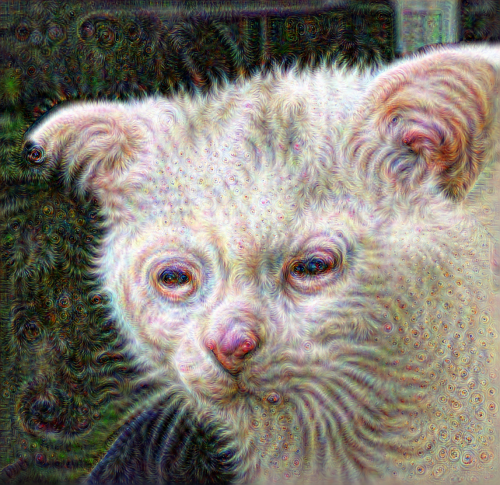

In [7]:
OCTAVE_SCALE = 1.4
#should tune these
target_layer = 20
EPOCH = 60
lr = 1e-3

img = init

orig_shape = np.array(init.size)
float_orig_shape = orig_shape.astype(np.float32)

img_res = None

for n in range(-5, 2):
  new_shape = (float_orig_shape * (OCTAVE_SCALE**n)).astype(np.int32)
  img = img.resize(new_shape, Image.ANTIALIAS) # https://stackoverflow.com/questions/1405602/how-to-adjust-the-quality-of-a-resized-image-in-python-imaging-library further reading?
  normalized_img = normalize(img)          # input to moddel needs to be h w at least 224, normalized.
  out = dream(normalized_img, model, modules, target_layer, lr, EPOCH)

  img_out = out.detach().cpu()
  denorm_img_out = denormalize(img_out)
  img_out = denorm_img_out.permute(1, 2, 0)
  img_out_np = img_out.numpy()
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))

  if (img_res):
    img_res2 = img_out_pil.resize(orig_shape, Image.ANTIALIAS)
    img_res = Image.blend(img_res, img_res2, 0.3) # (0.6 - (n + 3)) if want to change weight
    # print("BEFORE BLEND")
    # display(img_res2)
    # print("BLENDED: ")
    display(img_res)
  else:
    img_res = img_out_pil.resize(orig_shape, Image.ANTIALIAS)
    display(img_res)
  
